# Beta-diversity vs breeding history with corMLPE

Test hypotheses on release year vs MCC
Test hypothesis on unmerged dataset

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(foreach)
library(Hmisc)
library(lme4)
library(lmerTest)
library(ggplot2)
library(plyr)
library(dplyr)
library(tidyr)
library(pbkrtest)
library(gridExtra)
library(reshape2)
library(doParallel)
library(phyloseq)
library(MuMIn)


/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: survival

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Formula

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/home/brya

In [3]:
%%R
# Initialize corMLPE 
source('/home/bryan/corMLPE/corMLPE.R')

/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘nlme’


  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:dplyr’:

    collapse


  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:lme4’:

    lmList


  warnings.warn(x, RRuntimeWarning)


In [4]:
%%R
# set theme for ggplot

theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }


# Set up tables

## Loading phyloseq object

In [5]:
%%R
setwd('/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/')

In [6]:
%%R 
# loading

physeq = readRDS('ERA_snorm.rds')

#remove T0, not necessary
physeq = subset_samples(physeq, !is.na(Genotype), TRUE)
physeq = transform_sample_counts(physeq, sqrt)
physeq = subset_samples(physeq, SeedTreatment == "Treated" & Genotype != "Bare") # see seed treatment notebook for comparison


#See what happens with all plots, can subset latter
physeq = subset_samples(physeq, Fert == "85")
physeq = filter_taxa(physeq, function(x) sum(x > 0) > 0, TRUE)  
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 96 samples ]
sample_data() Sample Data:       [ 96 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [7]:
%%R
m.phy = subset_samples(physeq, TimePoint == "T2") %>%
        merge_samples("Plant")  %>%

    transform_sample_counts(function(x) x/sum(x))
        
m.phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 12 samples ]
sample_data() Sample Data:       [ 12 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [8]:
%%R
registerDoParallel(cores=28)
bray.dist = distance(m.phy, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


# Data wrangling 

### Melt unifrac distances

In [9]:
%%R
bd = as.matrix(bray.dist) 
# remove lower triangle to remove duplicate values
bd[ lower.tri( bd, diag = TRUE ) ]  <- NA
head(bd)
bd.m = melt(bd, na.rm= TRUE)

# rename columns
colnames(bd.m) = c("PlantA", "PlantB", "bray_Dist")
head(bd.m) %>% print
dim(bd.m) %>% print

   PlantA PlantB bray_Dist
13    322    330 0.1416862
25    322    339 0.1712911
26    330    339 0.1715275
37    322   3394 0.1487089
38    330   3394 0.1548160
39    339   3394 0.1537940
[1] 66  3


In [10]:
%%R
sd = sample_data(m.phy)

sd$Plant = rownames(sd)
## add Year of plant A and plant b
Dist= inner_join(bd.m, sd[,c("Plant","R_Year")], by = c("PlantA" = "Plant"))
colnames(Dist)[4] = "YearA"

Dist= inner_join(Dist, sd[,c("Plant","R_Year")], by = c("PlantB" = "Plant"))
colnames(Dist)[5] = "YearB"

Dist = mutate(Dist, YearDist = abs(YearA - YearB))
head(Dist)

  PlantA PlantB bray_Dist YearA YearB YearDist
1    322    330 0.1416862  1936  1939        3
2    322    339 0.1712911  1936  1942        6
3    330    339 0.1715275  1939  1942        3
4    322   3394 0.1487089  1936  1991       55
5    330   3394 0.1548160  1939  1991       52
6    339   3394 0.1537940  1942  1991       49


In [11]:
%%R
Dist %>% filter(PlantA == "3475")

  PlantA  PlantB bray_Dist YearA YearB YearDist
1   3475   34M95 0.1486369  1984  2001       17
2   3475   34N42 0.1574890  1984  2003       19
3   3475    3517 0.1544320  1984  1971       13
4   3475     354 0.1416345  1984  1953       31
5   3475    3541 0.1430688  1984  1975        9
6   3475    3618 0.1604575  1984  1961       23
7   3475 P1151HR 0.1492889  1984  2011       27


# Build corMLPE models

## Null model:
fit null model with random effect of sampling date to stratify covariance matrices

In [12]:
%%R
fitNull =  gls(bray_Dist ~ 1,
               correlation = corMLPE(form= ~ PlantA + PlantB), data = Dist, method = "ML")


In [13]:
%%R
summary(fitNull)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist ~ 1 
  Data: Dist 
        AIC       BIC   logLik
  -414.0714 -407.5025 210.0357

Correlation Structure: corMLPE
 Formula: ~PlantA + PlantB 
 Parameter estimate(s):
      Rho 
0.2426132 

Coefficients:
                Value   Std.Error t-value p-value
(Intercept) 0.1543081 0.003564586 43.2892       0

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.9389897 -0.7934650  0.0361539  0.5827148  2.6729660 

Residual standard error: 0.01187965 
Degrees of freedom: 66 total; 65 residual


In [14]:
%%R
#Add rep comparison, though maybe it is better to have explicit comp
fit1 =  gls(bray_Dist ~ poly(YearDist,2),
               correlation = corMLPE(form= ~ PlantA + PlantB), data = Dist, method = "ML")
summary(fit1)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist ~ poly(YearDist, 2) 
  Data: Dist 
       AIC       BIC  logLik
  -421.596 -410.6477 215.798

Correlation Structure: corMLPE
 Formula: ~PlantA + PlantB 
 Parameter estimate(s):
      Rho 
0.2726636 

Coefficients:
                         Value   Std.Error  t-value p-value
(Intercept)         0.15430808 0.003639134 42.40242  0.0000
poly(YearDist, 2)1 -0.00200861 0.008866009 -0.22655  0.8215
poly(YearDist, 2)2 -0.03092781 0.008953780 -3.45416  0.0010

 Correlation: 
                   (Intr) p(YD,2)1
poly(YearDist, 2)1 0.000          
poly(YearDist, 2)2 0.000  0.222   

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.2355498 -0.7351927 -0.0131829  0.6766430  2.4475658 

Residual standard error: 0.01137047 
Degrees of freedom: 66 total; 63 residual


In [15]:
%%R
MuMIn::r.squaredLR(fit1, null = fitNull)

[1] 0.1602198
attr(,"adj.r.squared")
[1] -0.0002762499


In [16]:
%%R
anova(fitNull, fit1)

        Model df       AIC       BIC   logLik   Test  L.Ratio p-value
fitNull     1  3 -414.0714 -407.5025 210.0357                        
fit1        2  5 -421.5960 -410.6477 215.7980 1 vs 2 11.52459  0.0031


In [17]:
%%R
CS = corMLPE(form= ~ PlantA + PlantB)

In [18]:
%%R
#Add rep comparison, though maybe it is better to have explicit comp
fit1.b =  gls(bray_Dist ~ I(YearDist) + I(YearDist^2), data = Dist,
          correlation = CS)
# correlation = corMLPE(form= ~ PlantA + PlantB)
summary(fit1.b)


Generalized least squares fit by REML
  Model: bray_Dist ~ I(YearDist) + I(YearDist^2) 
  Data: Dist 
        AIC       BIC   logLik
  -370.6428 -359.9271 190.3214

Correlation Structure: corMLPE
 Formula: ~PlantA + PlantB 
 Parameter estimate(s):
      Rho 
0.2824005 

Coefficients:
                    Value   Std.Error  t-value p-value
(Intercept)    0.14607995 0.004615662 31.64875   0e+00
I(YearDist)    0.00069752 0.000199456  3.49712   9e-04
I(YearDist^2) -0.00000993 0.000002858 -3.47275   9e-04

 Correlation: 
              (Intr) I(YrD)
I(YearDist)   -0.535       
I(YearDist^2)  0.454 -0.963

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.14985670 -0.70741286 -0.01308391  0.65072218  2.35329286 

Residual standard error: 0.0118238 
Degrees of freedom: 66 total; 63 residual


* Year of release as a polynomial function explains  16% of the variation!

In [19]:
%%R
summary(fit1.b)

Generalized least squares fit by REML
  Model: bray_Dist ~ I(YearDist) + I(YearDist^2) 
  Data: Dist 
        AIC       BIC   logLik
  -370.6428 -359.9271 190.3214

Correlation Structure: corMLPE
 Formula: ~PlantA + PlantB 
 Parameter estimate(s):
      Rho 
0.2824005 

Coefficients:
                    Value   Std.Error  t-value p-value
(Intercept)    0.14607995 0.004615662 31.64875   0e+00
I(YearDist)    0.00069752 0.000199456  3.49712   9e-04
I(YearDist^2) -0.00000993 0.000002858 -3.47275   9e-04

 Correlation: 
              (Intr) I(YrD)
I(YearDist)   -0.535       
I(YearDist^2)  0.454 -0.963

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.14985670 -0.70741286 -0.01308391  0.65072218  2.35329286 

Residual standard error: 0.0118238 
Degrees of freedom: 66 total; 63 residual


In [20]:
%%R
MuMIn::r.squaredLR(fit1.b, null = fitNull)

[1] 0.1599368
attr(,"adj.r.squared")
[1] -0.000275762


## Graphs

### phylogenetic distance vs microbial community

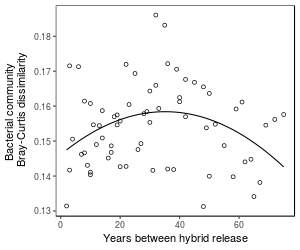

In [22]:
%%R -w 300 -h 250


model1 <- function(x) {-0.00000994313*x ^ 2 + 0.0006989301*x + 0.1461277}
# model1.CImin <- function(x) {-0.00001556209*x ^ 2 + 0.0003064501*x + 0.1372617}
# model1.CImax <- function(x) {-0.000004324189*x ^ 2 + 0.001091410*x + 0.1549937}

p = ggplot(Dist, aes(y = bray_Dist, x = YearDist)) 
p = p + geom_point(pch = 21) #aes(size = phy_Dist), shape = 1)
#p = p + stat_smooth(method = "lm", se = FALSE)
p = p + theme_pub()
#p = p + theme(panel.border = element_blank()) 
#p = p + theme(axis.line.x = element_line(color="black", size = 1),
 #   axis.line.y = element_line(color="black", size = 1))

p = p + stat_function(fun = model1)
# p = p + stat_function(fun = model1.CImin, linetype = "dashed")
# p = p + stat_function(fun = model1.CImax, linetype = "dashed")

p = p + labs(x = "Years between hybrid release")
p = p + labs(y = "Bacterial community \n Bray-Curtis dissimilarity")

p


# Repeat with outliers from ordination removed

In [23]:
%%R
m.phy = subset_samples(physeq, TimePoint == "T2" & !X.sampleID %in% c("ERA-T2_1-4c_85", "ERA-T2_4-4d_85" )) %>%
        merge_samples("Plant")  %>%


    transform_sample_counts(function(x) x/sum(x))
        
m.phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 12 samples ]
sample_data() Sample Data:       [ 12 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [24]:
%%R
registerDoParallel(cores=28)
bray.dist = distance(m.phy, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


# Data wrangling 

### Melt unifrac distances

In [25]:
%%R
bd = as.matrix(bray.dist) 
# remove lower triangle to remove duplicate values
bd[ lower.tri( bd, diag = TRUE ) ]  <- NA
head(bd)
bd.m = melt(bd, na.rm= TRUE)

# rename columns
colnames(bd.m) = c("PlantA", "PlantB", "bray_Dist")
head(bd.m) %>% print
dim(bd.m) %>% print

   PlantA PlantB bray_Dist
13    322    330 0.1416862
25    322    339 0.1663718
26    330    339 0.1690427
37    322   3394 0.1487089
38    330   3394 0.1548160
39    339   3394 0.1563968
[1] 66  3


In [26]:
%%R
sd = sample_data(m.phy)

sd$Plant = rownames(sd)
## add Year of plant A and plant b
Dist= inner_join(bd.m, sd[,c("Plant","R_Year")], by = c("PlantA" = "Plant"))
colnames(Dist)[4] = "YearA"

Dist= inner_join(Dist, sd[,c("Plant","R_Year")], by = c("PlantB" = "Plant"))
colnames(Dist)[5] = "YearB"

Dist = mutate(Dist, YearDist = abs(YearA - YearB))
head(Dist)

  PlantA PlantB bray_Dist YearA YearB YearDist
1    322    330 0.1416862  1936  1939        3
2    322    339 0.1663718  1936  1942        6
3    330    339 0.1690427  1939  1942        3
4    322   3394 0.1487089  1936  1991       55
5    330   3394 0.1548160  1939  1991       52
6    339   3394 0.1563968  1942  1991       49


## Null model:
fit null model with random effect of sampling date to stratify covariance matrices

In [27]:
%%R
fitNull =  gls(bray_Dist ~ 1,
               correlation = corMLPE(form= ~ PlantA + PlantB), data = Dist, method = "ML")


In [28]:
%%R
summary(fitNull)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist ~ 1 
  Data: Dist 
        AIC       BIC   logLik
  -414.4698 -407.9009 210.2349

Correlation Structure: corMLPE
 Formula: ~PlantA + PlantB 
 Parameter estimate(s):
      Rho 
0.3253946 

Coefficients:
                Value   Std.Error  t-value p-value
(Intercept) 0.1553704 0.004629872 33.55825       0

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-1.76885976 -0.76991474 -0.05479163  0.73493945  2.25372414 

Residual standard error: 0.01362281 
Degrees of freedom: 66 total; 65 residual


In [29]:
%%R
#Add rep comparison, though maybe it is better to have explicit comp
fit1 =  gls(bray_Dist ~ poly(YearDist,2),
               correlation = corMLPE(form= ~ PlantA + PlantB), data = Dist, method = "ML")
summary(fit1)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist ~ poly(YearDist, 2) 
  Data: Dist 
        AIC       BIC   logLik
  -417.8035 -406.8552 213.9018

Correlation Structure: corMLPE
 Formula: ~PlantA + PlantB 
 Parameter estimate(s):
      Rho 
0.3304908 

Coefficients:
                         Value   Std.Error  t-value p-value
(Intercept)         0.15537039 0.004528621 34.30854  0.0000
poly(YearDist, 2)1 -0.00224691 0.008862778 -0.25352  0.8007
poly(YearDist, 2)2 -0.02412268 0.008956893 -2.69320  0.0091

 Correlation: 
                   (Intr) p(YD,2)1
poly(YearDist, 2)1 0.000          
poly(YearDist, 2)2 0.000  0.238   

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-1.98669737 -0.70386622 -0.04471652  0.64155517  2.48372458 

Residual standard error: 0.01303014 
Degrees of freedom: 66 total; 63 residual


In [30]:
%%R
#Add rep comparison, though maybe it is better to have explicit comp
fit1.b =  gls(bray_Dist ~ I(YearDist) + I(YearDist^2),
               correlation = corMLPE(form= ~ PlantA + PlantB), data = Dist, method = "ML")
summary(fit1.b)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist ~ I(YearDist) + I(YearDist^2) 
  Data: Dist 
        AIC       BIC   logLik
  -417.8035 -406.8552 213.9018

Correlation Structure: corMLPE
 Formula: ~PlantA + PlantB 
 Parameter estimate(s):
      Rho 
0.3304908 

Coefficients:
                    Value   Std.Error   t-value p-value
(Intercept)    0.14908992 0.005261104 28.338142  0.0000
I(YearDist)    0.00053924 0.000199594  2.701665  0.0089
I(YearDist^2) -0.00000773 0.000002871 -2.693197  0.0091

 Correlation: 
              (Intr) I(YrD)
I(YearDist)   -0.467       
I(YearDist^2)  0.396 -0.963

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-1.98669737 -0.70386622 -0.04471652  0.64155517  2.48372458 

Residual standard error: 0.01303014 
Degrees of freedom: 66 total; 63 residual


In [31]:
%%R
anova(fit1)

Denom. DF: 63 
                  numDF   F-value p-value
(Intercept)           1 1177.0759  <.0001
poly(YearDist, 2)     2    3.7064  0.0301


In [32]:
%%R
MuMIn::r.squaredLR(fit1, null = fitNull)

[1] 0.1051653
attr(,"adj.r.squared")
[1] -0.0001802321


In [33]:
%%R
anova(fit1.b)

Denom. DF: 63 
              numDF   F-value p-value
(Intercept)       1 1177.0759  <.0001
I(YearDist)       1    0.1594  0.6911
I(YearDist^2)     1    7.2533  0.0091


In [34]:
%%R
anova(fitNull, fit1)

        Model df       AIC       BIC   logLik   Test  L.Ratio p-value
fitNull     1  3 -414.4698 -407.9009 210.2349                        
fit1        2  5 -417.8035 -406.8552 213.9017 1 vs 2 7.333672  0.0256


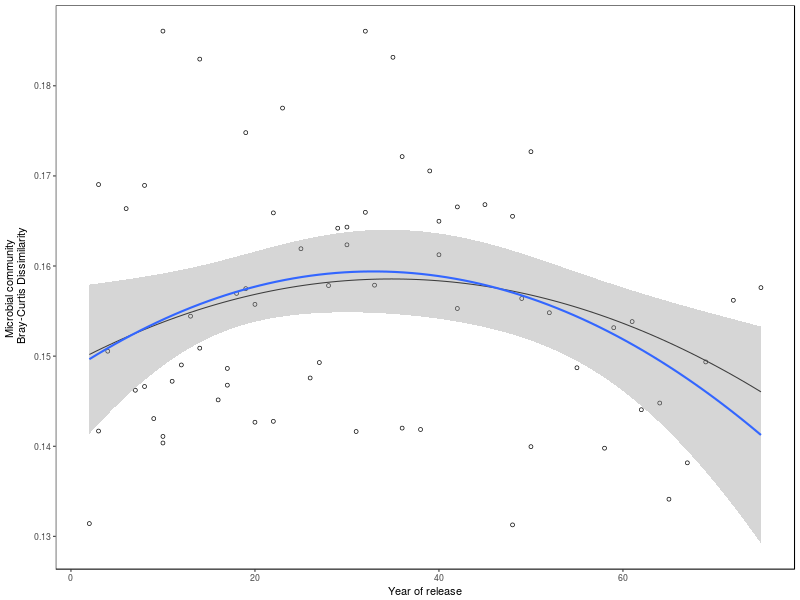

In [35]:
%%R -w 800 -h 600


model1 <- function(x) {-0.00000777*x ^ 2 + 0.00054149*x + 0.14913084}
# model1.CImin <- function(x) {-0.00001556209*x ^ 2 + 0.0003064501*x + 0.1372617}
# model1.CImax <- function(x) {-0.000004324189*x ^ 2 + 0.001091410*x + 0.1549937}

p = ggplot(Dist, aes(y = bray_Dist, x = YearDist)) 
p = p + geom_point(pch = 21) #aes(size = phy_Dist), shape = 1)
#p = p + stat_smooth(method = "lm", se = FALSE)
p = p + theme_pub()
#p = p + theme(panel.border = element_blank()) 
#p = p + theme(axis.line.x = element_line(color="black", size = 1),
 #   axis.line.y = element_line(color="black", size = 1))

p = p + stat_function(fun = model1)
p = p + stat_smooth(method = "lm", formula = y~ poly(x,2))
# p = p + stat_function(fun = model1.CImin, linetype = "dashed")
# p = p + stat_function(fun = model1.CImax, linetype = "dashed")

p = p + labs(x = "Year of release")
p = p + labs(y = "Microbial community \n Bray-Curtis Dissimilarity")

p


# Ok, now T1

In [36]:
%%R
m.phy = subset_samples(physeq, TimePoint == "T1") %>%
        merge_samples("Plant")  %>%


    transform_sample_counts(function(x) x/sum(x))
        
m.phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 6 samples ]
sample_data() Sample Data:       [ 6 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [37]:
%%R
registerDoParallel(cores=28)
bray.dist = distance(m.phy, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


# Data wrangling 

### Melt unifrac distances

In [38]:
%%R
bd = as.matrix(bray.dist) 
# remove lower triangle to remove duplicate values
bd[ lower.tri( bd, diag = TRUE ) ]  <- NA
head(bd)
bd.m = melt(bd, na.rm= TRUE)

# rename columns
colnames(bd.m) = c("PlantA", "PlantB", "bray_Dist")
head(bd.m) %>% print
dim(bd.m) %>% print

   PlantA PlantB bray_Dist
7     330   3475 0.1498719
13    330  34M95 0.1690555
14   3475  34M95 0.1570704
19    330   3517 0.1617041
20   3475   3517 0.1467838
21  34M95   3517 0.1490862
[1] 15  3


In [39]:
%%R
sd = sample_data(m.phy)

sd$Plant = rownames(sd)
## add Year of plant A and plant b
Dist= inner_join(bd.m, sd[,c("Plant","R_Year")], by = c("PlantA" = "Plant"))
colnames(Dist)[4] = "YearA"

Dist= inner_join(Dist, sd[,c("Plant","R_Year")], by = c("PlantB" = "Plant"))
colnames(Dist)[5] = "YearB"

Dist = mutate(Dist, YearDist = abs(YearA - YearB))
head(Dist)

  PlantA PlantB bray_Dist YearA YearB YearDist
1    330   3475 0.1498719  1939  1984       45
2    330  34M95 0.1690555  1939  2001       62
3   3475  34M95 0.1570704  1984  2001       17
4    330   3517 0.1617041  1939  1971       32
5   3475   3517 0.1467838  1984  1971       13
6  34M95   3517 0.1490862  2001  1971       30


## Null model:
fit null model with random effect of sampling date to stratify covariance matrices

In [40]:
%%R
fitNull =  gls(bray_Dist ~ 1,
               correlation = corMLPE(form= ~ PlantA + PlantB), data = Dist, method = "ML")


In [41]:
%%R
fit1 =  gls(bray_Dist ~ YearDist,
               correlation = corMLPE(form= ~ PlantA + PlantB), data = Dist, method = "ML")
summary(fit1)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist ~ YearDist 
  Data: Dist 
        AIC       BIC   logLik
  -92.14564 -89.31344 50.07282

Correlation Structure: corMLPE
 Formula: ~PlantA + PlantB 
 Parameter estimate(s):
      Rho 
0.3432679 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.15765201 0.006772761 23.277364  0.0000
YearDist    -0.00002464 0.000104843 -0.234992  0.8179

 Correlation: 
         (Intr)
YearDist -0.534

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-1.56490018 -0.69946999 -0.01525646  0.43624680  1.93317272 

Residual standard error: 0.01067082 
Degrees of freedom: 15 total; 13 residual


In [42]:
%%R
MuMIn::r.squaredLR(fit1, null = fitNull)

[1] 0.003632807
attr(,"adj.r.squared")
[1] -4.601076e-06


In [43]:
%%R
fit2 =  gls(bray_Dist ~ poly(YearDist, 2),
               correlation = corMLPE(form= ~ PlantA + PlantB), data = Dist, method = "ML")
summary(fit2)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist ~ poly(YearDist, 2) 
  Data: Dist 
        AIC       BIC   logLik
  -90.17311 -86.63286 50.08655

Correlation Structure: corMLPE
 Formula: ~PlantA + PlantB 
 Parameter estimate(s):
      Rho 
0.3522087 

Coefficients:
                         Value   Std.Error   t-value p-value
(Intercept)         0.15680285 0.006105542 25.682051  0.0000
poly(YearDist, 2)1 -0.00233014 0.008030705 -0.290154  0.7767
poly(YearDist, 2)2 -0.00123893 0.007416684 -0.167046  0.8701

 Correlation: 
                   (Intr) p(YD,2)1
poly(YearDist, 2)1 0.000          
poly(YearDist, 2)2 0.000  0.253   

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-1.57248776 -0.69962828 -0.01685063  0.46077526  1.93117990 

Residual standard error: 0.0108247 
Degrees of freedom: 15 total; 12 residual


In [44]:
%%R
MuMIn::r.squaredLR(fit2, null = fitNull)

[1] 0.005455696
attr(,"adj.r.squared")
[1] -6.909828e-06


In [45]:
%%R
anova(fitNull, fit1, fit2)

        Model df       AIC       BIC   logLik   Test    L.Ratio p-value
fitNull     1  3 -94.09105 -91.96690 50.04552                          
fit1        2  4 -92.14564 -89.31344 50.07282 1 vs 2 0.05459133  0.8153
fit2        3  5 -90.17311 -86.63286 50.08655 2 vs 3 0.02746816  0.8684


In [46]:
%%R
anova(fit1) %>% print
anova(fit2) %>% print

Denom. DF: 13 
            numDF  F-value p-value
(Intercept)     1 749.3268  <.0001
YearDist        1   0.0552  0.8179
Denom. DF: 12 
                  numDF  F-value p-value
(Intercept)           1 659.5677  <.0001
poly(YearDist, 2)     2   0.0468  0.9545


# Finally T3

In [47]:
%%R
m.phy = subset_samples(physeq, TimePoint == "T3") %>%
        merge_samples("Plant")  %>%


    transform_sample_counts(function(x) x/sum(x))
        
m.phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 6 samples ]
sample_data() Sample Data:       [ 6 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [48]:
%%R
registerDoParallel(cores=28)
bray.dist = distance(m.phy, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


# Data wrangling 

### Melt unifrac distances

In [49]:
%%R
bd = as.matrix(bray.dist) 
# remove lower triangle to remove duplicate values
bd[ lower.tri( bd, diag = TRUE ) ]  <- NA
head(bd)
bd.m = melt(bd, na.rm= TRUE)

# rename columns
colnames(bd.m) = c("PlantA", "PlantB", "bray_Dist")
head(bd.m) %>% print
dim(bd.m) %>% print

   PlantA PlantB bray_Dist
7     330   3475 0.1330519
13    330  34M95 0.1585380
14   3475  34M95 0.1579147
19    330   3517 0.1524254
20   3475   3517 0.1451101
21  34M95   3517 0.1621136
[1] 15  3


In [50]:
%%R
sd = sample_data(m.phy)

sd$Plant = rownames(sd)
## add Year of plant A and plant b
Dist= inner_join(bd.m, sd[,c("Plant","R_Year")], by = c("PlantA" = "Plant"))
colnames(Dist)[4] = "YearA"

Dist= inner_join(Dist, sd[,c("Plant","R_Year")], by = c("PlantB" = "Plant"))
colnames(Dist)[5] = "YearB"

Dist = mutate(Dist, YearDist = abs(YearA - YearB))
head(Dist)

  PlantA PlantB bray_Dist YearA YearB YearDist
1    330   3475 0.1330519  1939  1984       45
2    330  34M95 0.1585380  1939  2001       62
3   3475  34M95 0.1579147  1984  2001       17
4    330   3517 0.1524254  1939  1971       32
5   3475   3517 0.1451101  1984  1971       13
6  34M95   3517 0.1621136  2001  1971       30


## Null model:
fit null model with random effect of sampling date to stratify covariance matrices

In [51]:
%%R
fitNull =  gls(bray_Dist ~ 1,
               correlation = corMLPE(form= ~ PlantA + PlantB), data = Dist, method = "ML")


In [52]:
%%R
fit1 =  gls(bray_Dist ~ YearDist,
               correlation = corMLPE(form= ~ PlantA + PlantB), data = Dist, method = "ML")
summary(fit1)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist ~ YearDist 
  Data: Dist 
       AIC      BIC   logLik
  -88.4197 -85.5875 48.20985

Correlation Structure: corMLPE
 Formula: ~PlantA + PlantB 
 Parameter estimate(s):
      Rho 
0.3405039 

Coefficients:
                  Value   Std.Error   t-value p-value
(Intercept)  0.15554038 0.007634964 20.372116  0.0000
YearDist    -0.00001474 0.000119102 -0.123731  0.9034

 Correlation: 
         (Intr)
YearDist -0.538

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.8145900 -0.7688399  0.2182315  0.5593439  1.5224886 

Residual standard error: 0.01202768 
Degrees of freedom: 15 total; 13 residual


In [53]:
%%R
MuMIn::r.squaredLR(fit1, null = fitNull)

[1] 0.001158631
attr(,"adj.r.squared")
[1] -1.877221e-06


In [54]:
%%R
fit2 =  gls(bray_Dist ~ poly(YearDist, 2),
               correlation = corMLPE(form= ~ PlantA + PlantB), data = Dist, method = "ML")
summary(fit2)

Generalized least squares fit by maximum likelihood
  Model: bray_Dist ~ poly(YearDist, 2) 
  Data: Dist 
        AIC       BIC   logLik
  -86.75662 -83.21637 48.37831

Correlation Structure: corMLPE
 Formula: ~PlantA + PlantB 
 Parameter estimate(s):
      Rho 
0.3554215 

Coefficients:
                         Value   Std.Error   t-value p-value
(Intercept)         0.15503245 0.006904527 22.453741  0.0000
poly(YearDist, 2)1 -0.00241796 0.008965952 -0.269683  0.7920
poly(YearDist, 2)2 -0.00446720 0.008275890 -0.539785  0.5992

 Correlation: 
                   (Intr) p(YD,2)1
poly(YearDist, 2)1 0.000          
poly(YearDist, 2)2 0.000  0.255   

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.8683659 -0.7311081  0.2221399  0.4580386  1.5202263 

Residual standard error: 0.01220024 
Degrees of freedom: 15 total; 12 residual


In [55]:
%%R
MuMIn::r.squaredLR(fit2, null = fitNull)

[1] 0.02334388
attr(,"adj.r.squared")
[1] -3.78219e-05


In [56]:
%%R
anova(fitNull, fit1, fit2)

        Model df       AIC       BIC   logLik   Test   L.Ratio p-value
fitNull     1  3 -90.40231 -88.27816 48.20116                         
fit1        2  4 -88.41970 -85.58750 48.20985 1 vs 2 0.0173895  0.8951
fit2        3  5 -86.75662 -83.21637 48.37831 2 vs 3 0.3369205  0.5616


In [57]:
%%R
anova(fit1) %>% print
anova(fit2) %>% print

Denom. DF: 13 
            numDF  F-value p-value
(Intercept)     1 579.9778  <.0001
YearDist        1   0.0153  0.9034
Denom. DF: 12 
                  numDF  F-value p-value
(Intercept)           1 504.1705  <.0001
poly(YearDist, 2)     2   0.1550  0.8581


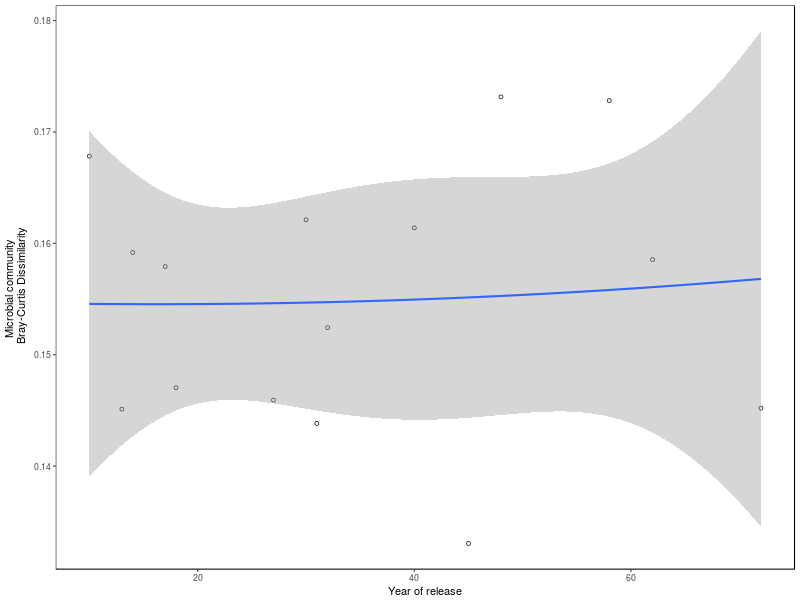

In [58]:
%%R -w 800 -h 600


#model1 <- function(x) {-0.00000777*x ^ 2 + 0.00054149*x + 0.14913084}
# model1.CImin <- function(x) {-0.00001556209*x ^ 2 + 0.0003064501*x + 0.1372617}
# model1.CImax <- function(x) {-0.000004324189*x ^ 2 + 0.001091410*x + 0.1549937}

p = ggplot(Dist, aes(y = bray_Dist, x = YearDist)) 
p = p + geom_point(pch = 21) #aes(size = phy_Dist), shape = 1)
#p = p + stat_smooth(method = "lm", se = FALSE)
p = p + theme_pub()
#p = p + theme(panel.border = element_blank()) 
#p = p + theme(axis.line.x = element_line(color="black", size = 1),
 #   axis.line.y = element_line(color="black", size = 1))

#p = p + stat_function(fun = model1)
p = p + stat_smooth(method = "lm", formula = y~ poly(x,2))
# p = p + stat_function(fun = model1.CImin, linetype = "dashed")
# p = p + stat_function(fun = model1.CImax, linetype = "dashed")

p = p + labs(x = "Year of release")
p = p + labs(y = "Microbial community \n Bray-Curtis Dissimilarity")

p